In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import seaborn as sns
import os

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn import datasets
from PIL import Image
from tqdm import tqdm

In [12]:
class config:
    image_size = (64, 64)
    components = 50

In [ ]:
def load_rgb_images(folder, label, size=config.image_size):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder), desc=f"Loading RGB from {folder}"):
        if filename.endswith('.jpg') or filename.endswith('.tiff'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB').resize(size)
            images.append(np.array(img).flatten()) 
            labels.append(label)
    return images, labels


def load_ndvi_images(folder, size=config.image_size):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder), desc=f"Loading NDVI from {folder}"):
        if filename.endswith('.jpg') or filename.endswith('.tiff'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize(size)  
            images.append(np.array(img).flatten()) 
            filenames.append(filename)
    return images, filenames


# load images into arrays

In [ ]:
label_path = "labels"   # NDVI images
sample_path = "samples" # RGB images

rgb_images, _ = load_rgb_images(sample_path, label=0)
samples_array = np.array(rgb_images)

ndvi_images, ndvi_filenames = load_ndvi_images(label_path)
labels_array = np.array(ndvi_images)


Loading NDVI from labels: 100%|██████████| 614/614 [00:00<00:00, 2237.44it/s]


In [15]:
mean_ndvi = np.nanmean(labels_array, axis=1)
threshold = np.median(mean_ndvi)

# Create binary labels based on NDVI:
# 0 = Unhealthy (NDVI <= threshold, darker pixels)
# 1 = Healthy (NDVI > threshold, lighter pixels)
y_labels = (mean_ndvi > threshold).astype(int)

print(f"Ground Truth Label Distribution (from NDVI):")
print(f"Class 0 (Unhealthy): {np.sum(y_labels == 0)} images")
print(f"Class 1 (Healthy):   {np.sum(y_labels == 1)} images")
print(f"\nNDVI Threshold: {threshold:.4f}")
print(f"Mean NDVI range: {mean_ndvi.min():.4f} to {mean_ndvi.max():.4f}")



Ground Truth Label Distribution (from NDVI):
Class 0 (Unhealthy): 307 images
Class 1 (Healthy):   307 images

NDVI Threshold: 176.6279
Mean NDVI range: 129.8091 to 201.4619


In [ ]:
X = samples_array
y = y_labels

print(f"Training data (grayscale RGB): {X.shape}")  # (n_samples, n_pixels)
print(f"Ground truth labels (NDVI):   {y.shape}")   # (n_samples,)

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set: {X_train.shape[0]} images")
print(f"Test set:  {X_test.shape[0]} images")

""" 
# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

# PCA
pca = PCA(n_components=config.components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Original shape (before PCA):", X_train.shape)
print("Shape after PCA:", X_train_pca.shape)


# SVM
# Create SVM with probability enabled
svm = SVC(kernel='rbf', probability=True, random_state=42)

# Then fit the model
svm.fit(X_train_pca, y_train)




Training data (grayscale RGB): (614, 12288)
Ground truth labels (NDVI):   (614,)

Train set: 491 images
Test set:  123 images
Original shape (before PCA): (491, 12288)
Shape after PCA: (491, 50)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [17]:
y_pred = svm.predict(X_test_pca)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.73      0.76        62
           1       0.75      0.82      0.78        61

    accuracy                           0.77       123
   macro avg       0.77      0.77      0.77       123
weighted avg       0.78      0.77      0.77       123



c:\Users\MSPun\Documents\Code\Research\Task 22\Learning_Path\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


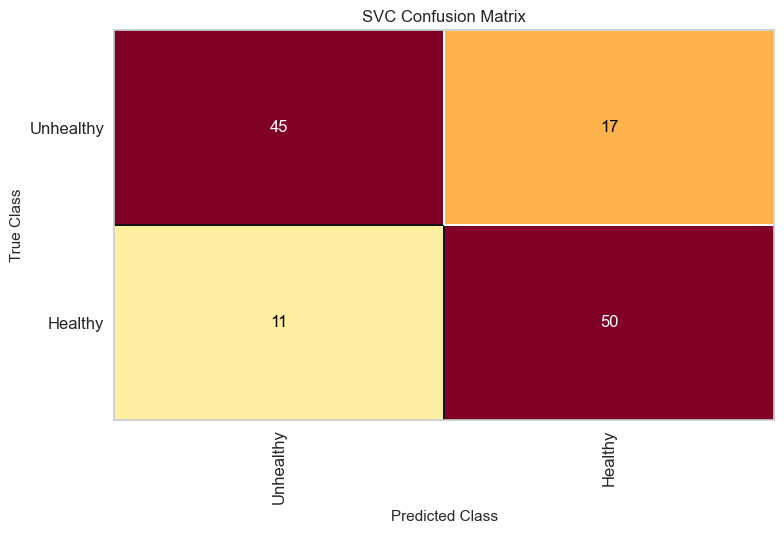

<Axes: title={'center': 'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [18]:
from yellowbrick.classifier import ConfusionMatrix

# Visualize confusion matrix
viz = ConfusionMatrix(svm, classes=["Unhealthy", "Healthy"])
viz.score(X_test_pca, y_test)
viz.show()



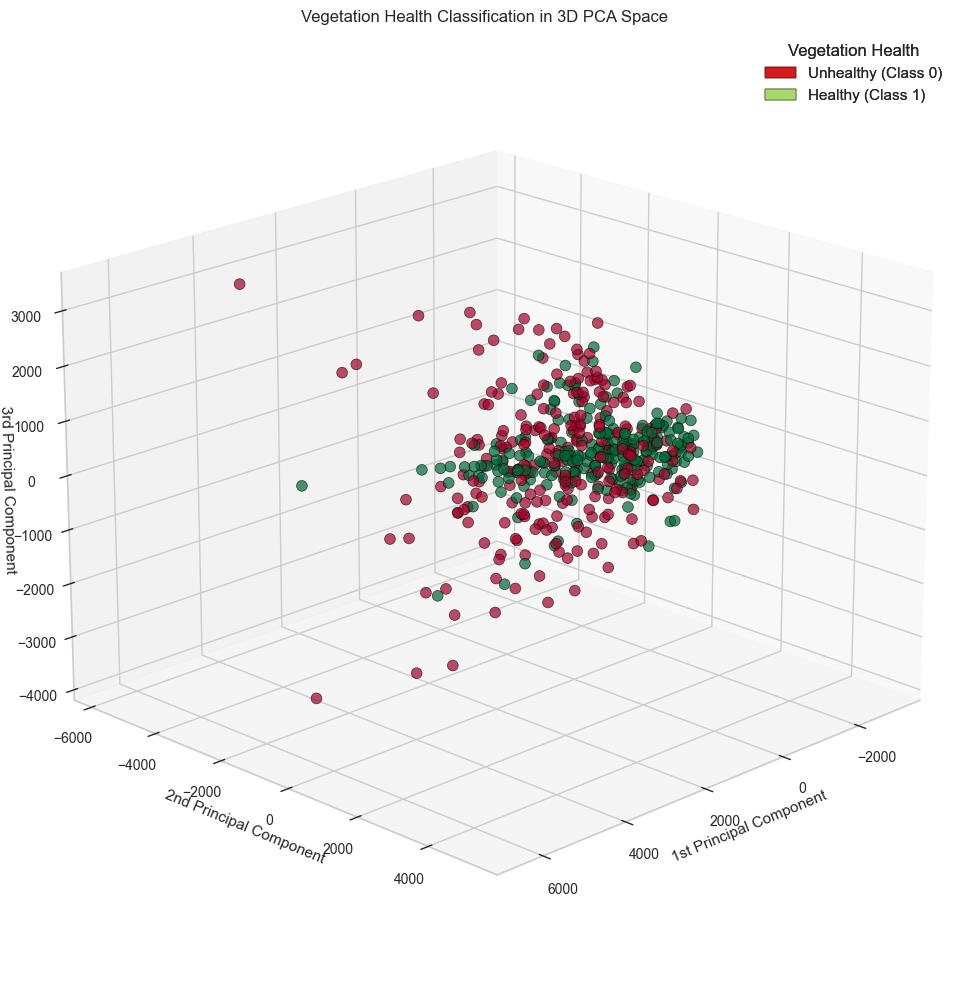

3D PCA VISUALIZATION ANALYSIS
Number of samples visualized: 491
Variance explained by first 3 components: 26.61%
  Component 1: 12.92%
  Component 2: 8.79%
  Component 3: 4.90%

Class distribution:
  Unhealthy (0): 245 samples
  Healthy (1):   246 samples


In [19]:
# ============================================================================
# 3D PCA VISUALIZATION (First 3 Principal Components)
# ============================================================================

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d", elev=20, azim=45)

# Use first 3 PCA components from your data
X_reduced = X_train_pca[:, :3]

# Create scatter plot with color-coded by class
scatter = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y_train,
    cmap=plt.cm.RdYlGn,
    s=60,
    alpha=0.7,
    edgecolors='black',
    linewidths=0.5
)

# Set labels and title
ax.set(
    title="Vegetation Health Classification in 3D PCA Space",
    xlabel="1st Principal Component",
    ylabel="2nd Principal Component",
    zlabel="3rd Principal Component",
)

# Add a custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d7191c', edgecolor='black', label='Unhealthy (Class 0)'),
    Patch(facecolor='#a6d96a', edgecolor='black', label='Healthy (Class 1)')
]
legend1 = ax.legend(
    handles=legend_elements,
    loc="upper right",
    title="Vegetation Health",
    fontsize=11
)
ax.add_artist(legend1)

# Add grid for better depth perception
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print 3D PCA statistics
print("="*70)
print("3D PCA VISUALIZATION ANALYSIS")
print("="*70)
print(f"Number of samples visualized: {len(X_reduced)}")
print(f"Variance explained by first 3 components: {np.sum(pca.explained_variance_ratio_[:3])*100:.2f}%")
print(f"  Component 1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  Component 2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Component 3: {pca.explained_variance_ratio_[2]*100:.2f}%")
print(f"\nClass distribution:")
print(f"  Unhealthy (0): {np.sum(y_train == 0)} samples")
print(f"  Healthy (1):   {np.sum(y_train == 1)} samples")
print("="*70)
